# Tweets Disaster Predictions

![DISASTERS!](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSqsnrxzRLZFSSg9SNtj9SM2eAHoBJIvqCBWInda9hfuVMXXLu1)

## A Basic Solution using BERT Deep Learning Google's Model

Hello everbody. The aim of this notebook is not to only share my solution of the NLP Disaster Prediction problem. I also want to show all the results that I got when I tried to improve the model.

You will se that all my tries were not better than the basic BERT and that's OK. We must remember that we are talking about Data **Science** and the "Science" part of the name is also composed by misleading results that can be reported to help in further studies :).

So, this guide is presented in the form of a really basic tutorial, as I usually like to do. It's also an opportunity to present the basic concepts of NLP and Transfer Learning to people who want to learn or review these concepts. So, let's start. But, before...

**An Important Acknowledgement to xhlulu:** [His notebook was really, REALLY useful for me](https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub) - In his notebook, the minimal BERT model is presented and he shows that it's possible to get an excellent result by using the original Google's Article BERT model, with the same parameters.

So, this notebook is composed by $5$ steps:
1. I show (again) the basic BERT model with a small guide to the concept of transfer learning and natural language processing, following the guideline proposed by xhulu.
2. EDA (Exploratory Data Analysis) + Used Models
3. Comparing the results of different models
4. Conclusions

# 1. Construction of a Basic BERT Model
## With a Fast Transfer Learning Guide

We start by taking the tokenization Google's Team script:

In [1]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)


Importing the used libraries:

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import tokenization
from plotnine import *
from tensorflow.keras.layers import Dense, Input, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit

And importing from the TensorFlow Hub the BERT model in the form of a Keras Neural Network layer:

In [3]:
%%time
import tensorflow_hub as hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 1min 36s, sys: 12.3 s, total: 1min 48s
Wall time: 1min 49s


Of course you can check the TensorFlow HUB website to find other models. You can, for example, take an alternative BERT version, the ALBERT, which is a smaller version of the model that is capable to also get nice results with a higher training speed.

![TensorHub](https://miro.medium.com/max/1600/1*3DSjKsIW08f3LBfGiNeovA.png)

We are working here with the concept of **Transfer Learning**: we take a pre-trained big deep learning neural network and add some layers to the original model (ocasionally we can also remove some layers of the pre-trained neural network) and with the adaptation of the learner we fit it to solve a new problem.

It's common to use this technique in Image Classification tasks and Natural Language Processing problems.

![TransferLearning](https://www.researchgate.net/profile/Joseph_Lemley/publication/316748306/figure/fig2/AS:491777640669185@1494260334992/Illustration-of-transfer-learning-concept-where-the-rst-layers-in-network-A-and-network-B.png)

Let's start! I aways start my storytelling scripts by loading the dataframes and taking a fast look at the training set:

In [4]:
input_dir = '/kaggle/input/nlp-getting-started/'
output_dir = '/kaggle/working/'
checkpoint_dir = '/kaggle/input/checkpoint-nlp-disaster/'
word1vec_dir = '/kaggle/input/word2vec-google/GoogleNews-vectors-negative300.bin'

df_model, df_submission = pd.read_csv(input_dir + 'train.csv'), pd.read_csv(input_dir + 'test.csv')
df_model.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Is our dataset balanced? The answer is YES! We have a distribution of nearly $40\% - 60\%$ of zeros and ones in our target column. So, the accuracy metric may be useful to our purposes:

In [5]:
df_model['target'].mean()

0.4296597924602653

Loading the tokenizer, which will be used to transform our words in ID numbers that will be processed by the BERT model (we have to assure that all words are in the lower case form in our problem):

In [6]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Writting a function to add columns of tokenized sentences. The tokenized sentences will be used as inputs of our deep learning neural network:

In [7]:
def tokenize_df(df_in):
    
    df_out = df_in.copy()
    df_out['str_tokens'] = df_out['text'].apply(tokenizer.tokenize)
    
    apply_cls_sep = lambda X: ['[CLS]'] + X + ['[SEP]']
    
    df_out['str_tokens'] = df_out['str_tokens'].apply(apply_cls_sep)
    df_out['id_tokens'] = df_out['str_tokens'].apply(tokenizer.convert_tokens_to_ids)
    df_out['n_tokens'] = df_out['id_tokens'].apply(len)
    
    return df_out

df_model = tokenize_df(df_model)
df_submission = tokenize_df(df_submission)
df_model.head()

,id,keyword,location,text,target,str_tokens,id_tokens,n_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[[CLS], our, deeds, are, the, reason, of, this...","[101, 2256, 15616, 2024, 1996, 3114, 1997, 202...",16
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[[CLS], forest, fire, near, la, ron, ##ge, sas...","[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...",12
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[[CLS], all, residents, asked, to, ', shelter,...","[101, 2035, 3901, 2356, 2000, 1005, 7713, 1999...",27
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[[CLS], 13, ,, 000, people, receive, #, wild, ...","[101, 2410, 1010, 2199, 2111, 4374, 1001, 3748...",14
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[[CLS], just, got, sent, this, photo, from, ru...","[101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...",22


Here comes an important part: we know that our sentences will aways have less than $140$ words (which is the Twitter limit  before the last update). But some sentences will have less than $140$ words. For example: if I say "deep learning is cool", we will have just $4$ words.

In this case, after the tokenization process, we will have something like: (0, 0, 0,..., 0, 123, 321, 13, 51). With $140 - 4$ zeros and $4$ number at the end representing the tokens of the words "deep", "learning", "is" and "cool", respectively. So, we will not update the neural network weights that are linked to non used word positions.

It's the concept of **masking** and we will tell the neural network with an argument that is equal to $1$ in positions of used words and equal to zero in unused positions. It's much similar to the concept of IP Masking (if you are familiar with the area of networking).

So, let's define a function to create those masks after zero left padding the the tokens:

In [8]:
def define_mask(df_in, window_size=140):
    df_out = df_in.copy()
    df_out['pad_size'] = window_size - df_out['n_tokens']
    
    masked_list, masked_id_token = list(), list()
    for i in range(0, df_out.shape[0]):
        masked_list.append([0] * df_out['pad_size'][i] + [1] * df_out['n_tokens'][i])
        masked_id_token.append([0] * df_out['pad_size'][i] + df_out['id_tokens'][i])
        
    df_out['masked_list'], df_out['masked_id_token'] = masked_list, masked_id_token
    return df_out
    
df_model = define_mask(df_model)
df_submission = define_mask(df_submission)
df_model.head()

,id,keyword,location,text,target,str_tokens,id_tokens,n_tokens,pad_size,masked_list,masked_id_token
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[[CLS], our, deeds, are, the, reason, of, this...","[101, 2256, 15616, 2024, 1996, 3114, 1997, 202...",16,124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[[CLS], forest, fire, near, la, ron, ##ge, sas...","[101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...",12,128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[[CLS], all, residents, asked, to, ', shelter,...","[101, 2035, 3901, 2356, 2000, 1005, 7713, 1999...",27,113,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[[CLS], 13, ,, 000, people, receive, #, wild, ...","[101, 2410, 1010, 2199, 2111, 4374, 1001, 3748...",14,126,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[[CLS], just, got, sent, this, photo, from, ru...","[101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...",22,118,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


And we are ready to define our basic BERT model:

In [9]:
def build_minimal_model(bert_layer, max_len=140):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

We can check the structure of our Neural Network with the summary function:

In [10]:
model = build_minimal_model(bert_layer, max_len=140)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 140)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

And, before start fitting our model, let's split the training and testing set with a stratified shuffle and split. When I say "stratified" I mean that the percentual of zeroes and ones in the training and validation sets will be nearly the same so we work with balanced samples:

![Stratification](https://doingsurveyresearch.files.wordpress.com/2013/01/strata-sample.gif)

In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
for train_index, test_index in sss.split(df_model, df_model['target']):
    df_model = df_model.iloc[test_index.tolist() + train_index.tolist(), :]

Here is a function to extract the model's inputs:

In [12]:
def extract_inputs(df_in, max_len=140):
    return np.array(df_in['masked_id_token'].tolist()),\
           np.array(df_in['masked_list'].tolist()),\
           np.array([[0] * max_len for i in range(0, df_in.shape[0])])

train_input = extract_inputs(df_model)
test_input = extract_inputs(df_submission)

train_labels = df_model['target']

I'm working with a flag that says whether or not I will run the models. If it's false, then we will load the obtained results of the last execution (since we are working with deep learning here, it's really easy to overflow the GPU memory)

In [13]:
flag_fit_models = False

If the flag is false, we load the last results, otherwise, we start the fitting process:

In [14]:
if flag_fit_models:
    train_history_minimal_model = model.fit(
        train_input, train_labels,
        validation_split=0.2,
        epochs=3,
        batch_size=16,
        callbacks=[EarlyStopping(restore_best_weights=True, patience=1)])
else:
    train_history_minimal_model = pd.read_csv(checkpoint_dir + 
                                              'train_history_minimal_model_no_label.csv')

If the flag is True, we output the new results:

In [15]:
if flag_fit_models:
    pd.DataFrame.from_dict(train_history_minimal_model.history).\
        to_csv(output_dir + 'train_history_minimal_model_no_label.csv', index=False)

    pd.DataFrame({
        'id': df_submission['id'],
        'target': [X[0] for X in list(model.predict(test_input))]
    }).to_csv(output_dir + 'predictions_model_no_sentence_labels.csv', index=False)
else:
    df_out = pd.read_csv(checkpoint_dir + 'predictions_model_no_sentence_labels.csv').loc[:, ['id', 'target']]
    df_out['target'] = df_out['target'].apply(lambda X: 1 if X >= 0.5 else 0)
    df_out.to_csv(output_dir + 'predictions_model_no_sentence_labels.csv', index=False)

The model results will be explored ahead in the models comparison section (**Section 5**). Before that, let's start our exploratory data analysis that lead me to alternative models.

# 2. Exploratory Data Analysis (EDA) + Used Models

We will create a dataframe with the parameters that we want to plot. I will follow an R "tidy" format and I will use the ggplot library to show the results:

In [16]:
df_eda = pd.DataFrame(dict(all_texts=df_model['text'].str.lower().str.split(), target=df_model['target'].tolist()))
df_eda.head()

,all_texts,target
3251,"[he, came, to, a, land, which, was, engulfed, ...",0
6015,"[*, screams, *]",0
4230,"[meg, issues, hazardous, weather, outlook, (hw...",1
512,"[christian, attacked, by, muslims, at, the, te...",1
1382,"[bush, fires, are, scary....even, scarier, whe...",1


The first auxiliary features that called me attention were: the number of hashtags in the sentence, the number of mentions (at's), the number of exclamation characters and the number of interrogations. These characters are eliminated from the text during the tokenization procedure and that's why I thought that, somehow, it would be possible to improve the model by adding these features to the input of the last Keras layer of the BERT model.

It makes sense since, in a certain way, these values are a proxy of the sentiment of the person who wrote the tweet:

In [17]:
df_eda['hashtag_count'] = df_eda['all_texts'].apply(lambda X: sum([1. for Y in X if Y[0] == '#']))
df_eda['at_count'] = df_eda['all_texts'].apply(lambda X: sum([1. for Y in X if Y[0] == '@']))
df_eda['exclamation_count'] = df_eda['all_texts'].apply(lambda X: sum([1. for Y in ''.join(X) if Y == '!']))
df_eda['interrogation_count'] = df_eda['all_texts'].apply(lambda X: sum([1. for Y in ''.join(X) if Y == '?']))

df_eda.head()

,all_texts,target,hashtag_count,at_count,exclamation_count,interrogation_count
3251,"[he, came, to, a, land, which, was, engulfed, ...",0,2.0,0.0,0.0,0.0
6015,"[*, screams, *]",0,0.0,0.0,0.0,0.0
4230,"[meg, issues, hazardous, weather, outlook, (hw...",1,1.0,0.0,0.0,0.0
512,"[christian, attacked, by, muslims, at, the, te...",1,0.0,0.0,0.0,0.0
1382,"[bush, fires, are, scary....even, scarier, whe...",1,0.0,0.0,0.0,0.0


We will also check whether or not each of these counts are bigger than $0$:

In [18]:
df_melt_eda = pd.melt(df_eda, id_vars=['target'], value_vars=['hashtag_count', 'at_count', 'exclamation_count'])
df_melt_eda['bigger_than_0'] = df_melt_eda['value'].apply(lambda X: 1. if X > 0 else 0)
df_melt_eda.head()

,target,variable,value,bigger_than_0
0,0,hashtag_count,2.0,1.0
1,0,hashtag_count,0.0,0.0
2,1,hashtag_count,1.0,1.0
3,1,hashtag_count,0.0,0.0
4,1,hashtag_count,0.0,0.0


Plotting the number of special characters for each target value:

/opt/conda/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/opt/conda/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/opt/conda/lib/python3.6/site-packages/plotnine/facets/facet.py:151: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  scales = Bunch()
/opt/conda/lib/python3.6/site-packages/plotnine/facets/layout.py:147: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  return Bunch(x=xsc, y=ysc)
/opt/conda/lib/python3.6/site-packages/plotnine/facets/facet.py:500

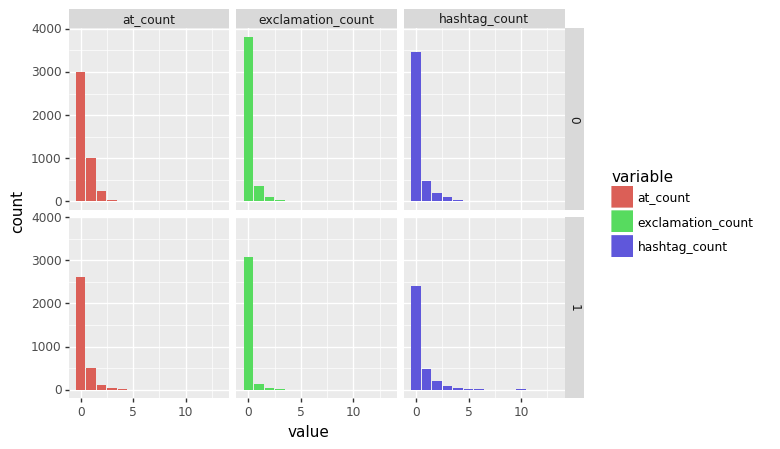

<ggplot: (-9223363303322338556)>

In [19]:
ggplot(aes(x='value', fill='variable'), data=df_melt_eda) + geom_bar() + facet_grid('target~variable')

It doesn't seem to let us assure that there is a relationship among these characters and the target value. Let's try a different approach: let's see the proportions of tweets with no spetial characters and with at least $1$ special character:

In [20]:
df_bigger_than_0_prob = df_melt_eda.groupby(['target', 'variable']).\
    agg({'bigger_than_0': ['mean', 'count']})

df_bigger_than_0_prob = df_bigger_than_0_prob['bigger_than_0'].reset_index()
df_bigger_than_0_prob['target'] = df_bigger_than_0_prob['target'].apply(lambda X: 'Disaster!' if X > 0 else 'Fake...')

df_bigger_than_0_prob['std'] = np.sqrt((df_bigger_than_0_prob['mean'] *\
                                       (1 - df_bigger_than_0_prob['mean'])) /\
                                       df_bigger_than_0_prob['count'])
df_bigger_than_0_prob['mean']
df_bigger_than_0_prob

,target,variable,mean,count,std
0,Fake...,at_count,0.306541,4342,0.006997
1,Fake...,exclamation_count,0.120451,4342,0.004940
2,Fake...,hashtag_count,0.201981,4342,0.006093
3,Disaster!,at_count,0.199939,3271,0.006993
4,Disaster!,exclamation_count,0.059921,3271,0.004150
5,Disaster!,hashtag_count,0.261999,3271,0.007688


Since we are studying a proportion, we can visually apply a hypothesis test: the variance of a proportion variable is given by:

$$\sqrt{\frac{p.(1-p)}{N}}$$

It happens because the mean of Bernouilli distributions follows a binominal distribution and we can take the binomial standard deviation formula to estimate the standard deviation of the mean, which will be plotted as error bars in the following plot:

(if you didn't understand this part, it's ok! :) just continue to read and consider that the error bars must not cross one over another if we want to be sure that these features really have any influence over the target)

/opt/conda/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/opt/conda/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/opt/conda/lib/python3.6/site-packages/plotnine/facets/facet.py:151: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  scales = Bunch()
/opt/conda/lib/python3.6/site-packages/plotnine/facets/layout.py:147: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  return Bunch(x=xsc, y=ysc)
/opt/conda/lib/python3.6/site-packages/plotnine/guides/guide_legend

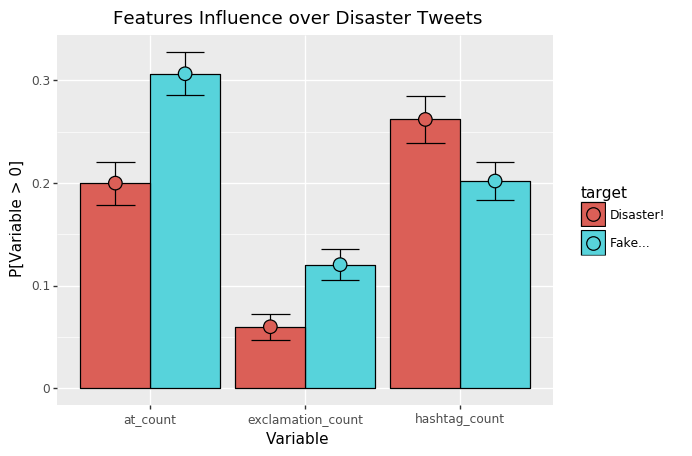

<ggplot: (8733528542945)>

In [21]:
ggplot(df_bigger_than_0_prob, aes(x='variable', fill = 'target', group='target')) +\
    geom_bar(aes(y='mean'), position = 'dodge', stat='identity', color='black') +\
    geom_errorbar(aes(ymin='mean - 3 * std', 
                      ymax='mean + 3 * std'), 
                  position = position_dodge(0.9), width=0.5) +\
    geom_point(aes(y='mean'), position = position_dodge(0.9), size=5) +\
    xlab('Variable') + ylab('P[Variable > 0]') + ggtitle('Features Influence over Disaster Tweets')

So, with this positive result, I tried to create a model that used these features as aditional inputs to the last Dense Layer of the minimal BERT model presented in the first section. But, as we will see in the **Section 3** (Comparing Models), the effect was not interesting.

I also tried to write an autocorrector script using the concepts of [this notebook](https://www.kaggle.com/cpmpml/spell-checker-using-word2vec). It consists in three steps:

1. Check the candidates that are similar to the words of the Word2Vec Google's Dictionary (we consider that 2 words are similar if we can transform the invalid word into a valid one with few insertions, deletions or permutations of characters)
2. We take the most probable candidate (using the Word2Vec's inverse rank value as a proxy of the probability)
3. The most likely candidate is used as correction

I tried to apply this function to the words before the tokenization steps. The results didn't get better as we will see in the next section.

Noting that the autospelling script didn't work, I just applied the tokenization algorithm over the locations and keywords without concerning with the correctness of the new strings that will be added to the model.

Why the autocorrection didn't improve the model? My hypothesis can be found in a comment of the tokenization script imported at the beggining of the notebook:

    This uses a greedy longest-match-first algorithm to perform tokenization
    using the given vocabulary.
    For example:
      input = "unaffable"
      output = ["un", "##aff", "##able"]
      
So, the code breaks invalid words in a sequence of common suffixes and prefixes in order to get the longest match to valid words. That concept seems to work really well with the BERT neural network structure:

![BERT Structure](https://cdn-images-1.medium.com/max/800/0*ViwaI3Vvbnd-CJSQ.png)

Thinking a little bit more about the structure of the BERT Neural Network, I got an idea: the BERT neural network also takes as inputs the segment ID's of each word. So, the last solution that I tried consists in just concatenate the location and the keyword of each row to the text, after zero-pad them with zeros.

In this new model, I didt not not use $0$ as the ID for all tokens:

- The segment ID of the location tokens would be equal to 0
- The segment ID of the keyword tokens would be equal to 1 and
- The segment ID of the original text would be equal to 2

But I got the same "problem": I didn't get any improvement with this model. Let's compare the obtained results in the next section.

Well, let's continue our EDA and try to find more features:

In [22]:
df_model['n_characters'] = df_model['text'].apply(lambda X: len(''.join(X.split())))
df_model['n_']

KeyError: 'n_'

# 3. Comparing Models

Importing the saved histories:

In [23]:
def index_to_row(df_in):
    df_in['Epoch'] = df_in.index
    return df_in

history_extra_features = index_to_row(pd.read_csv(checkpoint_dir + 'train_history_extra_features.csv'))
history_minimal_model_no_label = index_to_row(pd.read_csv(checkpoint_dir + 'train_history_minimal_model_no_label.csv'))
history_minimal_model_with_label = index_to_row(pd.read_csv(checkpoint_dir + 'train_history_minimal_model_with_label.csv'))
history_with_correction = index_to_row(pd.read_csv(checkpoint_dir + 'train_history_with_correction.csv'))

In [24]:
history_extra_features['Model'] = 'Extra Features'
history_minimal_model_no_label['Model'] = 'Minimal'
history_minimal_model_with_label['Model'] = 'Label'
history_with_correction['Model'] = 'Auto Correction'

df_histories = pd.concat([
    history_extra_features,
    history_minimal_model_no_label,
    history_minimal_model_with_label,
    history_with_correction
], axis=0, ignore_index=True)

df_histories.head()

,loss,accuracy,val_loss,val_accuracy,Epoch,Model
0,0.479528,0.780624,0.399125,0.826001,0,Extra Features
1,0.347236,0.855993,0.402765,0.830598,1,Extra Features
2,0.472571,0.777504,0.406378,0.838477,0,Minimal
3,0.329922,0.865846,0.394055,0.836507,1,Minimal
4,0.243776,0.903941,0.412795,0.839790,2,Minimal


/opt/conda/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/opt/conda/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/opt/conda/lib/python3.6/site-packages/plotnine/facets/facet.py:151: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  scales = Bunch()
/opt/conda/lib/python3.6/site-packages/plotnine/facets/layout.py:147: MatplotlibDeprecationWarning: The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  return Bunch(x=xsc, y=ysc)
/opt/conda/lib/python3.6/site-packages/plotnine/guides/guide_legend

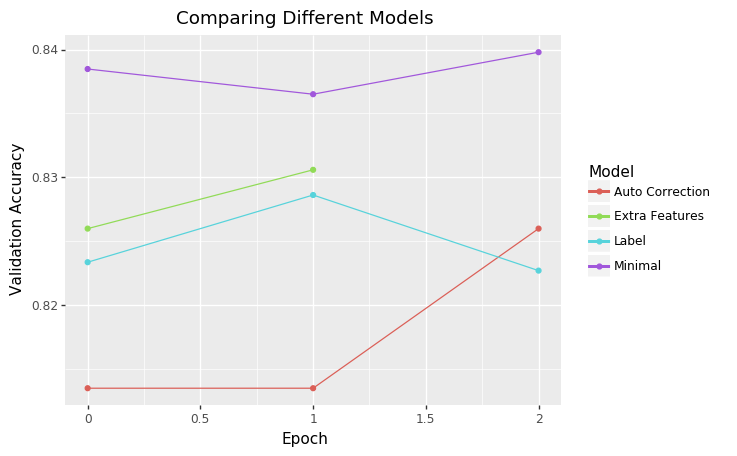

<ggplot: (8733528547020)>

In [25]:
ggplot(df_histories, aes(x='Epoch', y='val_accuracy', color='Model', group='Model')) +\
    geom_line() + geom_point() + labs(title='Comparing Different Models') +\
    ylab('Validation Accuracy')

We have no choice: we will keep using the minimal Google's BERT model. So, for now, my submission will use the BERT original model with just one Dense layer. Anyway, I still have other plans to try to improve the estimator: I will try to create smaller models and blend them with the output of the obtained neural network. Maybe it can help us to achieve better results.

# 5. Conclusions

The conclusions, for this first public version of my notebook are:

* It seems that it doesn't matter what you try to do: the minimal BERT model is aways better
* Auto correction scripts also seem to not be useful at all: the maximum long path search algorithm from the Google Team's tokenizer script is capable to solve the problem of ortograph assuring a better final result
* Special characters like #, !, @ and ? have an influence over the probability to have a fake news tweet but adding them to the BERT model didn't seem to improve the validation accuracy

So, my next step is to improve the EDA in a new version and try to write a stacked model.